In [33]:
import seaborn as sns
import seaborn.objects as so

from scipy import stats
import numpy as np

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from formulaic import model_matrix

from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios


In [34]:
def generar_datos(n=1000, amin=0, amax=20, bmin=5, bmax=20, seed=2906):
    np.random.seed(seed)
    brange = bmax - bmin
    a = stats.uniform.rvs(size=n, loc=amin, scale=amax - amin)
    b = stats.norm.rvs(size=n, loc=bmin + brange / 2, scale=brange / 8)
    eps = stats.norm.rvs(size=n, loc=0, scale=4)
    y = 1 + 3 * a - 2 * b + 1.5 * a * b - 0.8 * a**2 + 0.6 * b**2 + eps
    return pd.DataFrame({"a": a, "b": b}), pd.Series(y)

X, y = generar_datos()

In [35]:
X

,a,b
0,8.734133,15.394511
1,13.034632,12.525557
2,17.034105,10.551190
3,10.817888,15.382497
4,9.217678,13.748394
...,...,...
995,8.671706,12.553847
996,6.947835,8.640205
997,4.878641,14.271576
998,11.313032,16.268229


In [36]:
y

0      280.324677
1      216.688679
2      131.789786
3      303.421562
4      235.852460
          ...    
995    195.343680
996    102.264704
997    200.028047
998    333.430498
999    110.685708
Length: 1000, dtype: float64

In [37]:
# Graficamos la variable respuesta y, en funcion de las explicativas a y b en dos gráficos separados

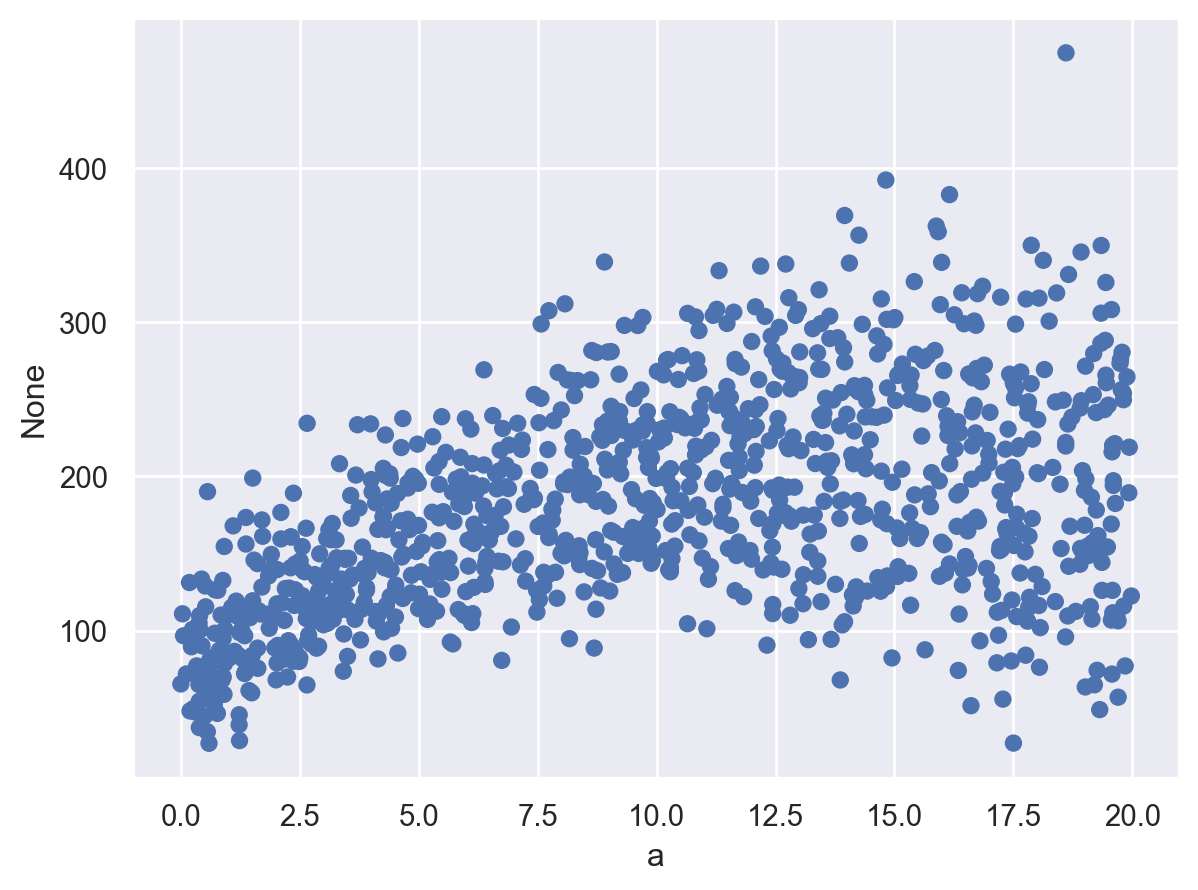

In [38]:
(
    so.Plot(x = X.a, y = y)
    .add(so.Dot())
)

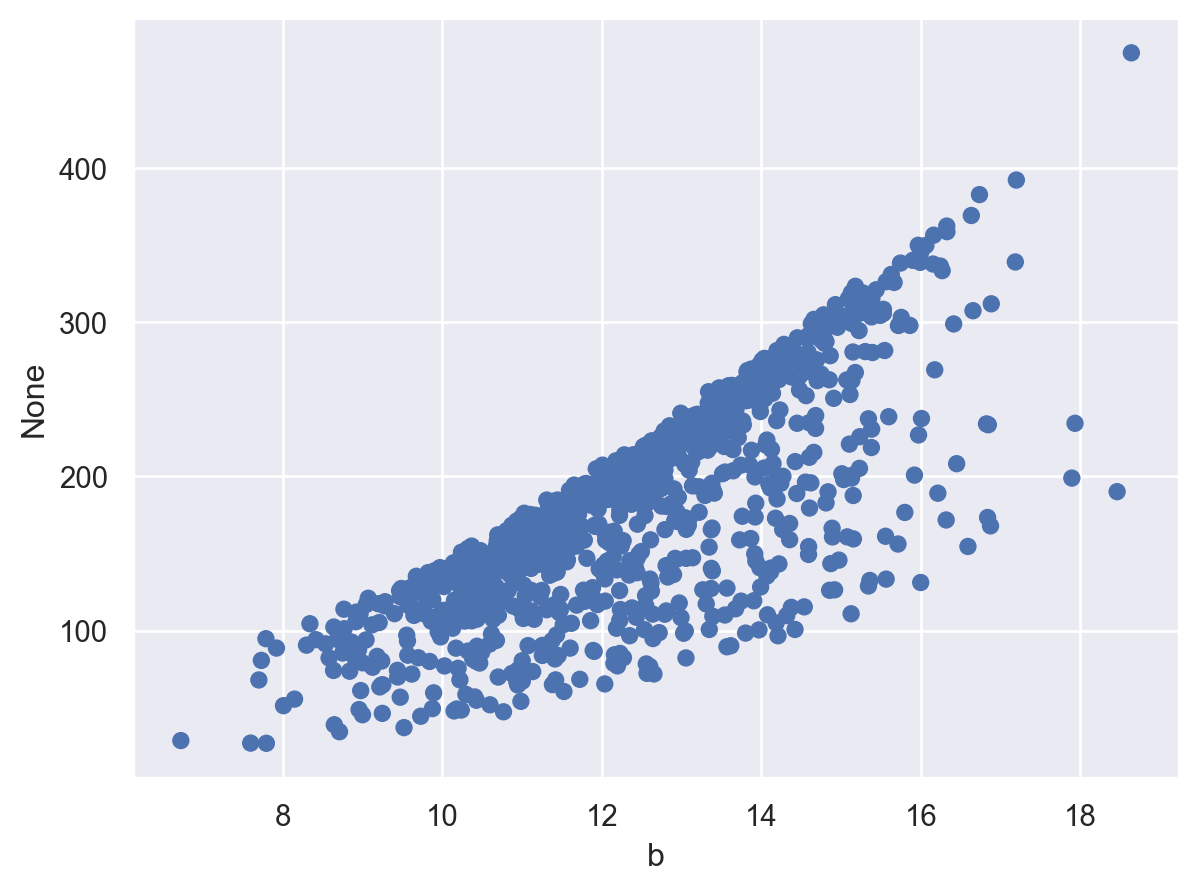

In [39]:
(
    so.Plot(x = X.b, y = y)
    .add(so.Dot())
)

In [7]:
# Probamos primero un modelo lineal
test_split = 0.95
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)

In [8]:
modeloLineal1 = LinearRegression()
modeloLineal1.fit(X_train, y_train)

LinearRegression()

In [9]:
# Guardamos los coeficientes en forma prolija
beta1 = pd.Series(modeloLineal1.coef_, index=X_train.columns)
beta1["intercept"] = modeloLineal1.intercept_
beta1

a              5.902323
b             27.182741
intercept   -222.798293
dtype: float64

In [17]:
# Calculando el ECM en entrenamiento y testeo

# ECM train
y_pred = modeloLineal1.predict(X_train)
ecm = mean_squared_error(y_train, y_pred)
print('Raiz cuadarada del ECM en entrenamiento: ', np.sqrt(ecm))

# ECM test
y_pred = modeloLineal1.predict(X_test)
ecm = mean_squared_error(y_test, y_pred)
print('Raiz cuadarada del ECM en testeo: ', np.sqrt(ecm))

Raiz cuadarada del ECM en entrenamiento:  34.279182665433574
Raiz cuadarada del ECM en testeo:  30.385006476618642


## Análisis de residuos

Llamamos residuo al error en la predicción, es decir la diferencia entre el valor real y el valor predicho (y - y_pred).

Queremos ver si hay estructura en los residuos o parecen aleatorios.

Si hay estructura significa que hay alguna relación que no estamos teniendo en cuenta en el modelo.



In [ ]:
# Ponemos todo en un solo DataFrame
# Podemos usar también pd.concat, pero tenemos que tener cuidado con los índices!
df_test = X_test.copy()
df_test["y"] = y_test
df_test["y_pred"] = y_pred
df_test["resid"] = df_test["y"] - df_test["y_pred"] # el residuo es y - y_pred
df_test.head()

,a,b,y,y_pred,resid
794,1.538997,14.974040,145.689348,193.320803,-47.631455
53,10.536718,14.864426,278.266955,243.448651,34.818304
295,1.430469,11.002242,80.422197,84.715882,-4.293686
393,6.096735,15.384311,230.637771,231.374354,-0.736582
164,6.399261,10.439719,129.905577,98.752382,31.153195


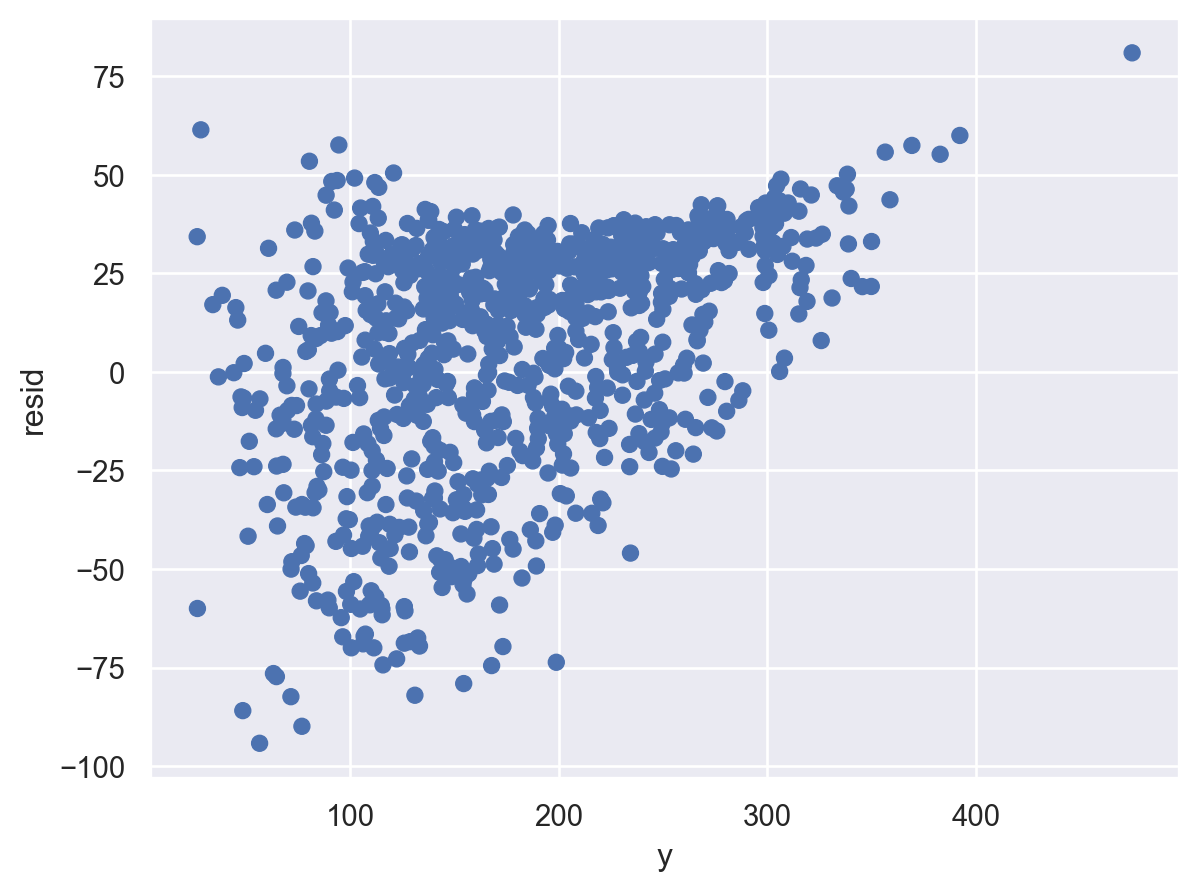

In [12]:
# Residuos en función de y
(
    so.Plot(x = df_test.y, y = df_test.resid)
    .add(so.Dot())
)

In [281]:
# Esto nos muestra que estamos prediciendo por abajo en los valores grandes de y, pero no hay mucho que podamos hacer porque no conocemos y.

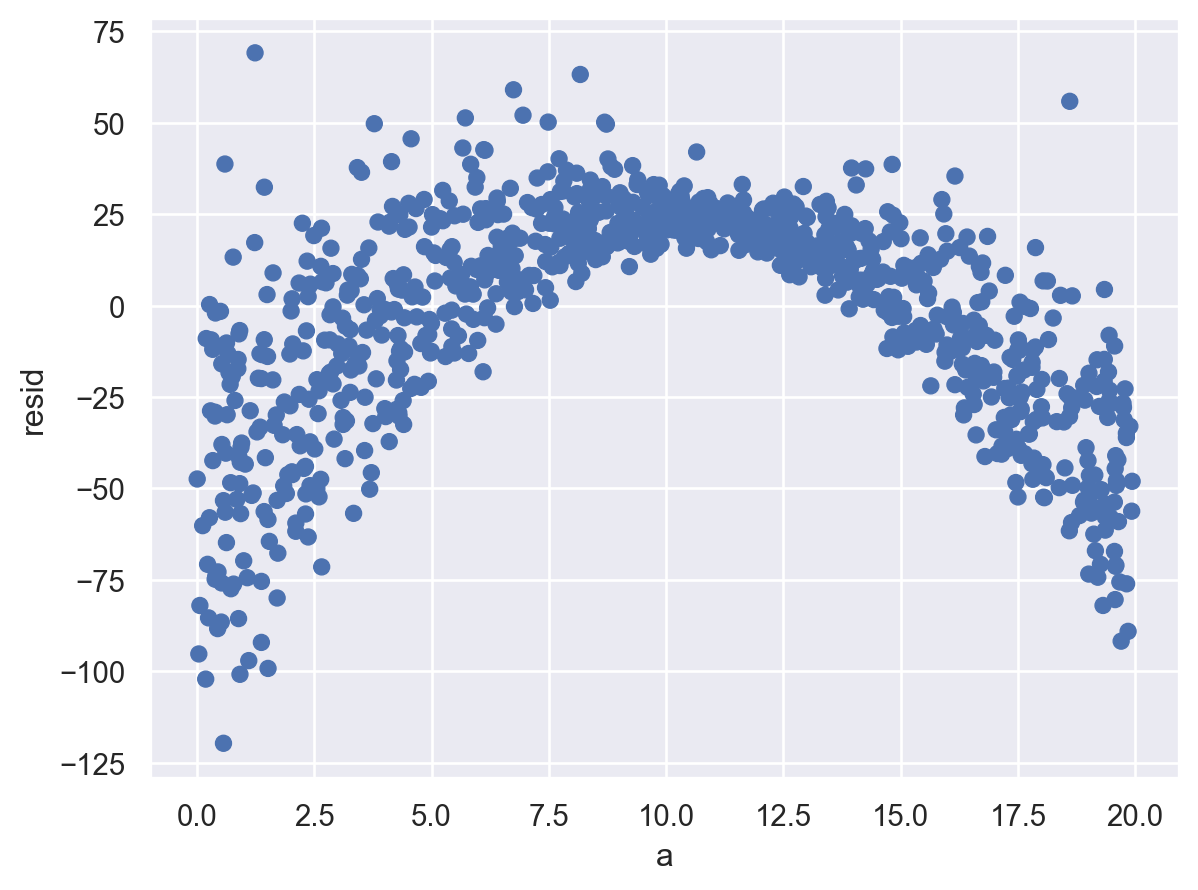

In [15]:
# Residuos en función de a
(
    so.Plot(x = df_test.a, y = df_test.resid)
    .add(so.Dot())
)

In [16]:
# Que sugiere esto?

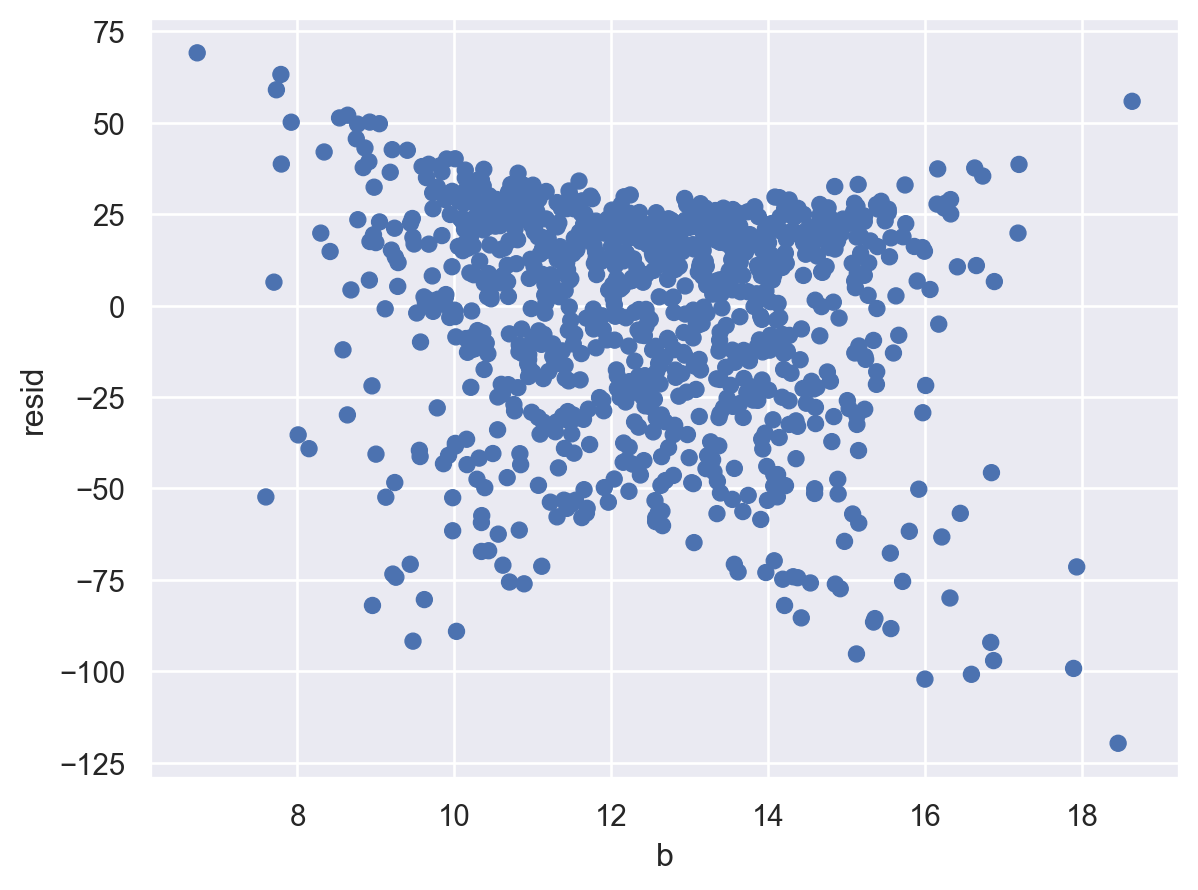

In [17]:
# Residuos en función de b
(
    so.Plot(x = df_test.b, y = df_test.resid)
    .add(so.Dot())
)

In [41]:
# No vemos mucha estructura acá, o es más dificil de saber qué hacer a partir de estos residuos.
X_train.head()

,a,b
590,2.507826,13.931940
95,4.951585,12.496852
129,3.448732,13.058426
687,2.808996,11.860099
956,9.711211,15.754853


In [42]:
# Comenzamos por agregar un término cuadrático en a.
formula = "~ poly(a, 2) + b"  # Esto aplica una normalización para evitar valores muy grandes
X_train2 = model_matrix(formula, data= X_train)
X_train2.head()

,Intercept,"poly(a, 2)[1]","poly(a, 2)[2]",b
590,1.0,-0.173097,0.096428,13.931940
95,1.0,-0.114637,-0.049927,12.496852
129,1.0,-0.150588,0.033235,13.058426
687,1.0,-0.165892,0.075269,11.860099
956,1.0,-0.000776,-0.169065,15.754853


In [43]:
# Ajustamos
modeloLineal2 = LinearRegression()
modeloLineal2.fit(X_train2, y_train)

# Calculando el ECM en entrenamiento

# ECM train
y_pred2 = modeloLineal2.predict(X_train2)
ecm = mean_squared_error(y_train, y_pred2)
print('Raiz cuadarada del ECM en entrenamiento: ', np.sqrt(ecm))

Raiz cuadarada del ECM en entrenamiento:  16.161644668703076


In [20]:
# Como calculamos las predicciones? Tenemos que aplicar la misma transformación en testeo!
# La salida de formulaic no es solo la matriz, tambien guarda información de la transforamción
X_train2.model_spec

ModelSpec(formula=1 + poly(a, 2) + b, materializer='pandas', materializer_params={}, ensure_full_rank=True, na_action=<NAAction.DROP: 'drop'>, output='pandas', cluster_by=<ClusterBy.NONE: 'none'>, structure=[EncodedTermStructure(term=1, scoped_terms=[1], columns=['Intercept']), EncodedTermStructure(term=poly(a, 2), scoped_terms=[poly(a, 2)], columns=['poly(a, 2)[1]', 'poly(a, 2)[2]']), EncodedTermStructure(term=b, scoped_terms=[b], columns=['b'])], transform_state={'poly(a, 2)': {'alpha': {0: 9.743665095137265, 1: 10.091624147023033}, 'norms2': {1: 1747.4355345692045, 0: 50.0, 2: 42702.18088522177}}}, encoder_state={'poly(a, 2)': (<Kind.NUMERICAL: 'numerical'>, {}), 'b': (<Kind.NUMERICAL: 'numerical'>, {})})

In [ ]:
ms = X_train2.model_spec # guardamos la información de la transformación

In [24]:
# Ahora podemos aplicar esas especificaciones a cualquier DataFrame! 
# En este caso seria un error aplicar la misma "fórmula", necesitamos aplicar las mismas transformaciones
X_test2 = ms.get_model_matrix(X_test)
X_test2

,Intercept,"poly(a, 2)[1]","poly(a, 2)[2]",b
794,1.0,-0.196273,0.170451,14.974040
53,1.0,0.018972,-0.167416,14.864426
295,1.0,-0.198869,0.179308,11.002242
393,1.0,-0.087242,-0.098621,15.384311
164,1.0,-0.080005,-0.109366,10.439719
...,...,...,...,...
366,1.0,-0.085723,-0.100951,12.447188
140,1.0,0.042426,-0.156890,13.399353
895,1.0,0.158913,0.033237,12.065621
493,1.0,-0.130432,-0.016083,12.112459


In [44]:
# Ahora si podemos calcular las predicciones en testeo

# Calculando el ECM en testeo

# ECM test
y_pred2 = modeloLineal2.predict(X_test2)
ecm = mean_squared_error(y_test, y_pred2)
print('Raiz cuadarada del ECM en testeo: ', np.sqrt(ecm))

Raiz cuadarada del ECM en testeo:  19.827078819307015


In [24]:
# Analizamos nuevamente los residuos

In [45]:
df_test2 = X_test.copy()
df_test2["y"] = y_test # No necesitamos las variables generadas
df_test2["y_pred"] = y_pred2
df_test2["resid"] = df_test2["y"] - df_test2["y_pred"]
df_test2.head()

,a,b,y,y_pred,resid
794,1.538997,14.974040,145.689348,156.084941,-10.395592
53,10.536718,14.864426,278.266955,277.954957,0.311998
295,1.430469,11.002242,80.422197,47.883467,32.538729
393,6.096735,15.384311,230.637771,251.158846,-20.521075
164,6.399261,10.439719,129.905577,123.667504,6.238073


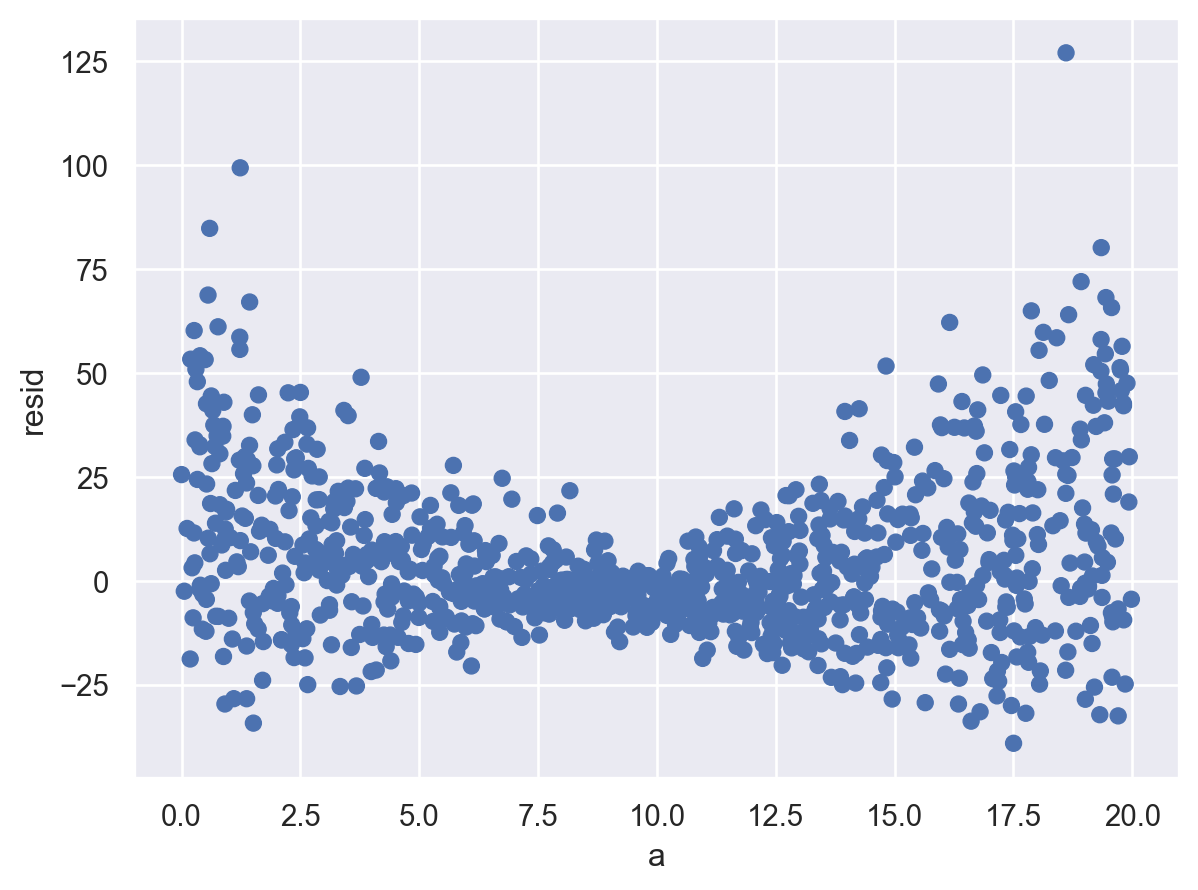

In [27]:
# Residuos en función de a
(
    so.Plot(x = df_test2.a, y = df_test2.resid)
    .add(so.Dot())
)

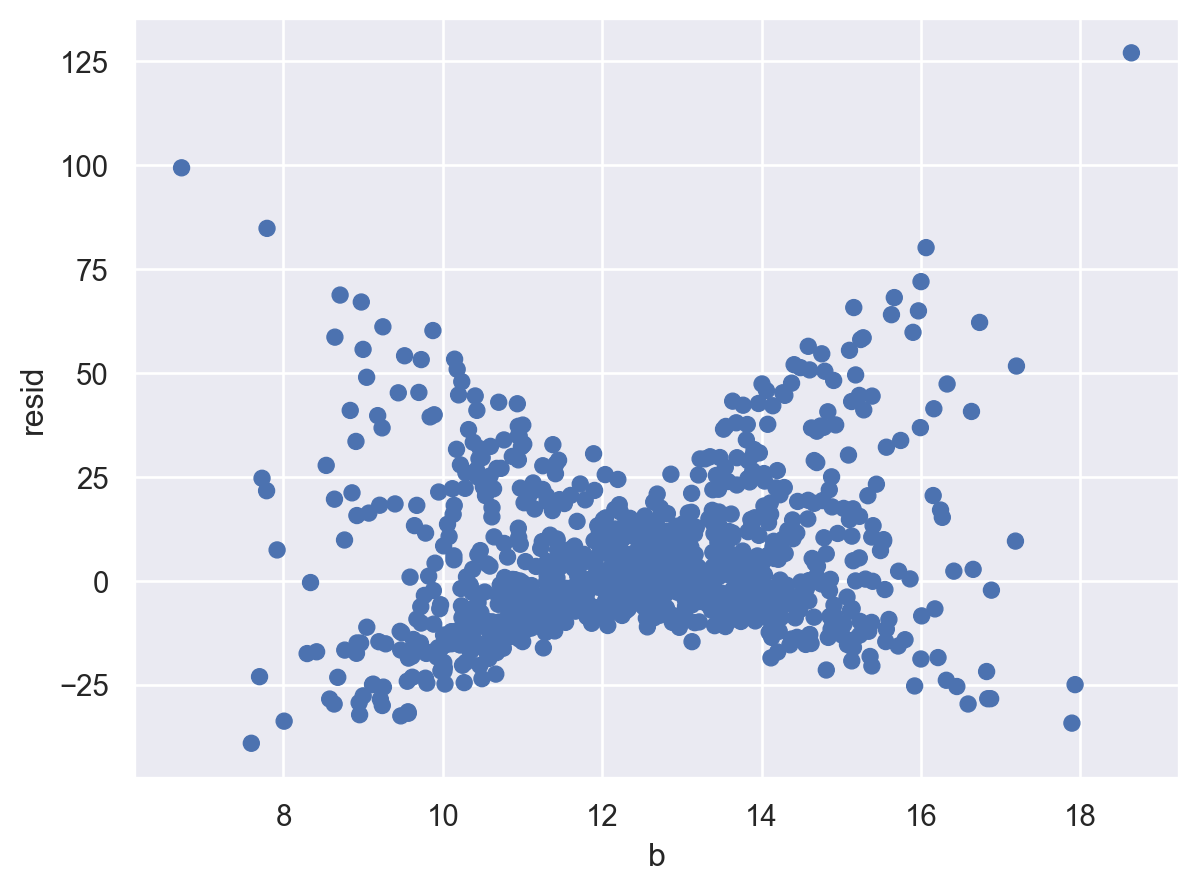

In [46]:
# Residuos en función de b
(
    so.Plot(x = df_test2.b, y = df_test2.resid)
    .add(so.Dot())
)

In [47]:
# Agregamos interacciones
# Comenzamos por agregar un término cuadrático en a.
formula = "~ poly(a, 2) * b"  # Esto aplica una normalización para evitar valores muy grandes
X_train3 = model_matrix(formula, data= X_train)
X_train3.head()

,Intercept,"poly(a, 2)[1]","poly(a, 2)[2]",b,"poly(a, 2)[1]:b","poly(a, 2)[2]:b"
590,1.0,-0.173097,0.096428,13.931940,-2.411570,1.343433
95,1.0,-0.114637,-0.049927,12.496852,-1.432597,-0.623934
129,1.0,-0.150588,0.033235,13.058426,-1.966443,0.433997
687,1.0,-0.165892,0.075269,11.860099,-1.967494,0.892694
956,1.0,-0.000776,-0.169065,15.754853,-0.012232,-2.663588


In [48]:
# Ajustamos
modeloLineal3 = LinearRegression()
modeloLineal3.fit(X_train3, y_train)

# Calculando el ECM en entrenamiento

# ECM train
y_pred3 = modeloLineal3.predict(X_train3)
ecm = mean_squared_error(y_train, y_pred3)
print('Raiz cuadarada del ECM en entrenamiento: ', np.sqrt(ecm))

Raiz cuadarada del ECM en entrenamiento:  4.958905069326059


In [49]:
# Calculamos el ECM en testeo

ms = X_train3.model_spec

# Generamos la matriz
X_test3 = ms.get_model_matrix(X_test)
X_test3.head()

,Intercept,"poly(a, 2)[1]","poly(a, 2)[2]",b,"poly(a, 2)[1]:b","poly(a, 2)[2]:b"
794,1.0,-0.196273,0.170451,14.974040,-2.938999,2.552333
53,1.0,0.018972,-0.167416,14.864426,0.282001,-2.488545
295,1.0,-0.198869,0.179308,11.002242,-2.188007,1.972793
393,1.0,-0.087242,-0.098621,15.384311,-1.342162,-1.517223
164,1.0,-0.080005,-0.109366,10.439719,-0.835232,-1.141751


In [50]:
# ECM test
y_pred3 = modeloLineal3.predict(X_test3)
ecm = mean_squared_error(y_test, y_pred3)
print('Raiz cuadarada del ECM en testeo: ', np.sqrt(ecm))

Raiz cuadarada del ECM en testeo:  5.587997300754682


In [51]:
df_test3 = X_test.copy()
df_test3["y"] = y_test # No necesitamos las variables generadas
df_test3["y_pred"] = y_pred3
df_test3["resid"] = df_test3["y"] - df_test3["y_pred"]
df_test3.head()

,a,b,y,y_pred,resid
794,1.538997,14.974040,145.689348,147.255932,-1.566583
53,10.536718,14.864426,278.266955,279.969419,-1.702464
295,1.430469,11.002242,80.422197,73.862960,6.559237
393,6.096735,15.384311,230.637771,241.711163,-11.073392
164,6.399261,10.439719,129.905577,128.458131,1.447446


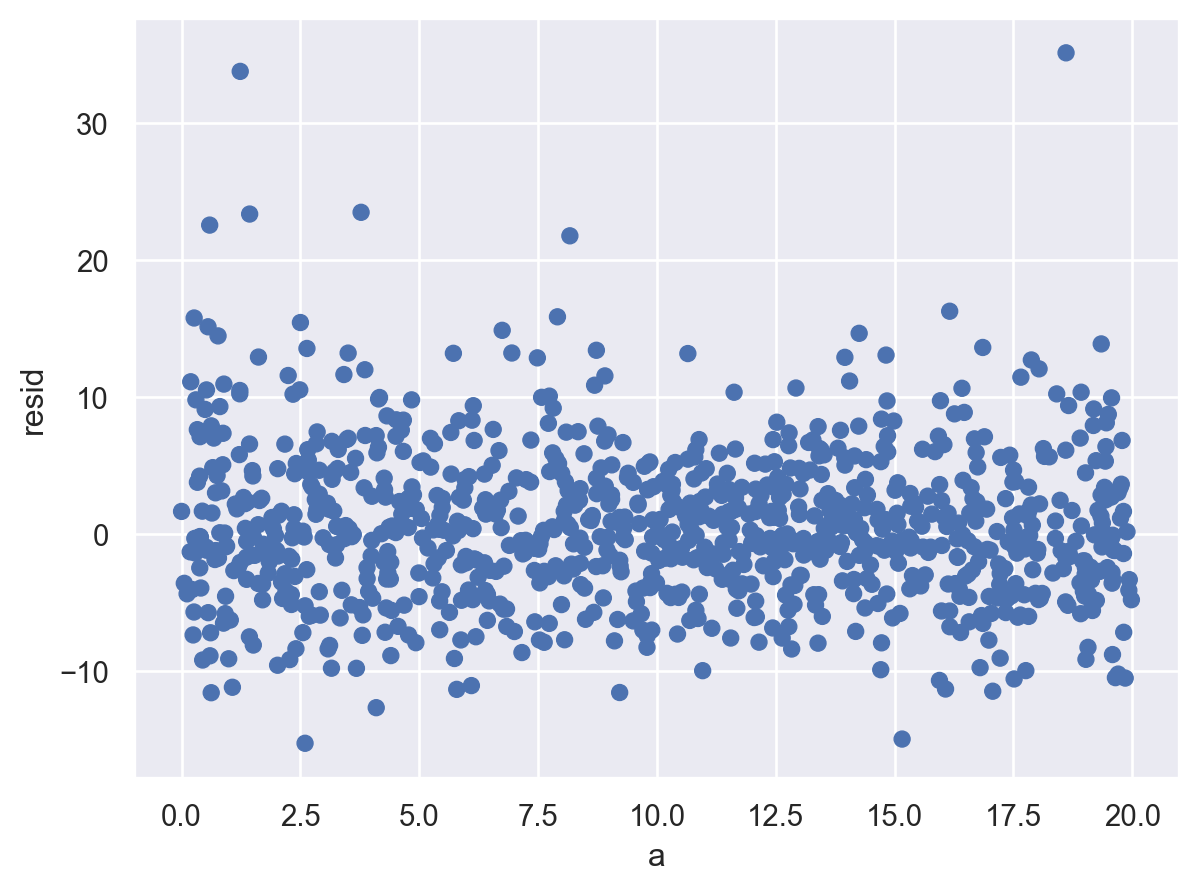

In [52]:
# Residuos en función de a
(
    so.Plot(x = df_test3.a, y = df_test3.resid)
    .add(so.Dot())
)

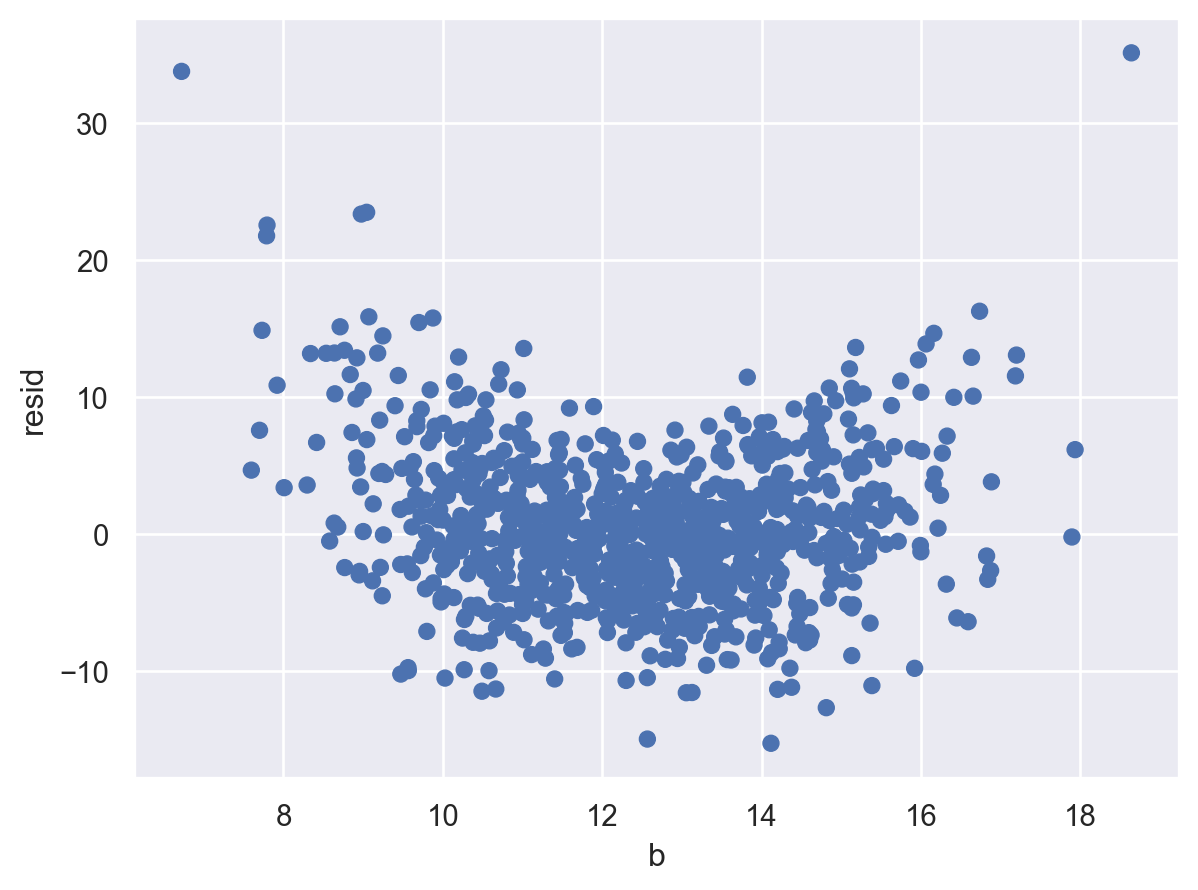

In [53]:
# Residuos en función de b
(
    so.Plot(x = df_test3.b, y = df_test3.resid)
    .add(so.Dot())
)

Podemos seguir agregando términos e interacciones de mayor grado. Vamos a hacer regresión Ridge para evitar el sobreajuste.

In [54]:
from sklearn.linear_model import Ridge

formula = "~ poly(a, 4) * poly(b, 4) - 1"
X_train4 = model_matrix(formula, data=X_train)
ms = X_train4.model_spec
X_train4

,"poly(a, 4)[1]","poly(a, 4)[2]","poly(a, 4)[3]","poly(a, 4)[4]","poly(b, 4)[1]","poly(b, 4)[2]","poly(b, 4)[3]","poly(b, 4)[4]","poly(a, 4)[1]:poly(b, 4)[1]","poly(a, 4)[2]:poly(b, 4)[1]",...,"poly(a, 4)[3]:poly(b, 4)[2]","poly(a, 4)[4]:poly(b, 4)[2]","poly(a, 4)[1]:poly(b, 4)[3]","poly(a, 4)[2]:poly(b, 4)[3]","poly(a, 4)[3]:poly(b, 4)[3]","poly(a, 4)[4]:poly(b, 4)[3]","poly(a, 4)[1]:poly(b, 4)[4]","poly(a, 4)[2]:poly(b, 4)[4]","poly(a, 4)[3]:poly(b, 4)[4]","poly(a, 4)[4]:poly(b, 4)[4]"
590,-0.173097,0.096428,0.024785,-0.117711,0.082501,-0.078746,-0.087851,0.064640,-0.014281,0.007955,...,-0.001952,0.009269,0.015207,-0.008471,-0.002177,0.010341,-0.011189,0.006233,0.001602,-0.007609
95,-0.114637,-0.049927,0.158842,-0.080680,-0.012812,-0.098455,0.056353,0.084264,0.001469,0.000640,...,-0.015639,0.007943,-0.006460,-0.002814,0.008951,-0.004547,-0.009660,-0.004207,0.013385,-0.006798
129,-0.150588,0.033235,0.101516,-0.137385,0.024486,-0.101686,0.000338,0.105323,-0.003687,0.000814,...,-0.010323,0.013970,-0.000051,0.000011,0.000034,-0.000046,-0.015860,0.003500,0.010692,-0.014470
687,-0.165892,0.075269,0.053154,-0.130369,-0.055103,-0.077769,0.107173,0.022669,0.009141,-0.004148,...,-0.004134,0.010139,-0.017779,0.008067,0.005697,-0.013972,-0.003761,0.001706,0.001205,-0.002955
956,-0.000776,-0.169065,0.011901,0.153797,0.203572,0.078788,-0.154005,-0.210719,-0.000158,-0.034417,...,0.000938,0.012117,0.000120,0.026037,-0.001833,-0.023686,0.000164,0.035625,-0.002508,-0.032408
803,0.237549,0.291335,0.314972,0.299208,-0.131951,0.006128,0.127735,-0.127684,-0.031345,-0.038442,...,0.001930,0.001834,0.030343,0.037214,0.040233,0.038220,-0.030331,-0.037199,-0.040217,-0.038204
440,-0.054195,-0.140472,0.121743,0.084777,-0.189153,0.107356,0.047748,-0.171148,0.010251,0.026571,...,0.013070,0.009101,-0.002588,-0.006707,0.005813,0.004048,0.009275,0.024042,-0.020836,-0.014509
772,-0.175509,0.103709,0.014445,-0.111939,0.038353,-0.099299,-0.021440,0.103795,-0.006731,0.003978,...,-0.001434,0.011115,0.003763,-0.002223,-0.000310,0.002400,-0.018217,0.010765,0.001499,-0.011619
538,0.048093,-0.152951,-0.096307,0.100175,0.005284,-0.101780,0.029940,0.098916,0.000254,-0.000808,...,0.009802,-0.010196,0.001440,-0.004579,-0.002883,0.002999,0.004757,-0.015129,-0.009526,0.009909
253,0.185461,0.108680,-0.020848,-0.127877,0.088431,-0.074483,-0.095939,0.055630,0.016401,0.009611,...,0.001553,0.009525,-0.017793,-0.010427,0.002000,0.012268,0.010317,0.006046,-0.001160,-0.007114


In [55]:
# Para definir los alfas, podemos usar np.logspace (valores espaciados en progresión geométrica)
np.logspace(0, 2, 5)

array([  1.        ,   3.16227766,  10.        ,  31.6227766 ,
       100.        ])

In [56]:
# Generamos un vector de alfas
alfas = np.logspace(-7, 1, 61)
alfas

array([1.00000000e-07, 1.35935639e-07, 1.84784980e-07, 2.51188643e-07,
       3.41454887e-07, 4.64158883e-07, 6.30957344e-07, 8.57695899e-07,
       1.16591440e-06, 1.58489319e-06, 2.15443469e-06, 2.92864456e-06,
       3.98107171e-06, 5.41169527e-06, 7.35642254e-06, 1.00000000e-05,
       1.35935639e-05, 1.84784980e-05, 2.51188643e-05, 3.41454887e-05,
       4.64158883e-05, 6.30957344e-05, 8.57695899e-05, 1.16591440e-04,
       1.58489319e-04, 2.15443469e-04, 2.92864456e-04, 3.98107171e-04,
       5.41169527e-04, 7.35642254e-04, 1.00000000e-03, 1.35935639e-03,
       1.84784980e-03, 2.51188643e-03, 3.41454887e-03, 4.64158883e-03,
       6.30957344e-03, 8.57695899e-03, 1.16591440e-02, 1.58489319e-02,
       2.15443469e-02, 2.92864456e-02, 3.98107171e-02, 5.41169527e-02,
       7.35642254e-02, 1.00000000e-01, 1.35935639e-01, 1.84784980e-01,
       2.51188643e-01, 3.41454887e-01, 4.64158883e-01, 6.30957344e-01,
       8.57695899e-01, 1.16591440e+00, 1.58489319e+00, 2.15443469e+00,
      

In [59]:
X_test4 = ms.get_model_matrix(X_test)

rmse_train = {}  # Resulta útil guardar los valores en un diccionario
rmse_test = {}
intercept = {}
for alfa in alfas:
    ridge = Ridge(alpha=alfa)
    ridge.fit(X_train4, y_train)
    rmse_train[alfa] =  np.sqrt(mean_squared_error(ridge.predict(X_train4), y_train))
    rmse_test[alfa] =  np.sqrt(mean_squared_error(ridge.predict(X_test4), y_test))
    intercept[alfa] = ridge.intercept_

In [61]:
# Convertimos a DataFrame para graficar
data = pd.DataFrame(
    {
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "intercept": intercept,
    }
).reset_index(names="alfa")
data

,alfa,rmse_train,rmse_test,intercept
0,1.000000e-07,2.605337,22.311974,182.072590
1,1.359356e-07,2.605387,21.803296,182.145573
2,1.847850e-07,2.605469,21.171348,182.236644
3,2.511886e-07,2.605597,20.406918,182.347453
4,3.414549e-07,2.605788,19.511826,182.478200
...,...,...,...,...
56,2.928645e+00,51.769667,55.140262,179.665426
57,3.981072e+00,54.885998,58.089391,179.665416
58,5.411695e+00,57.494828,60.546506,179.664500
59,7.356423e+00,59.620439,62.540228,179.663124


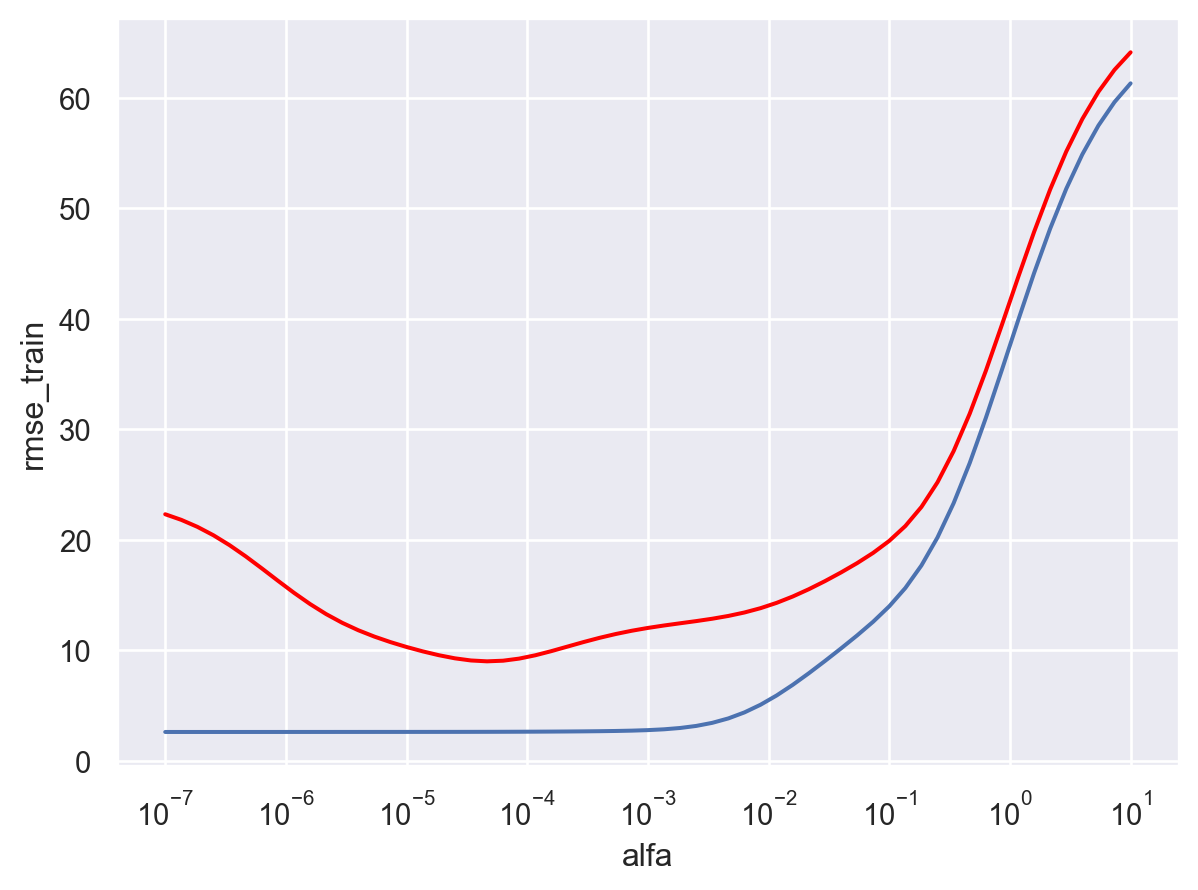

In [62]:
# Residuos en función de a
(
    so.Plot(data = data, x= "alfa").scale(x = "log")
    .add(so.Line(), y = "rmse_train")
    .add(so.Line(color = "red"), y = "rmse_test")
)

In [42]:
# Automatizamos la búsqueda con comandos de sklearn

In [43]:
# La primera opción es usar GridSearch

In [63]:
from sklearn.model_selection import GridSearchCV

alfas = np.logspace(-7, 1, 61)

param_grid = {"alpha": alfas}
gs = GridSearchCV(
    Ridge(),
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    return_train_score=True,
)
gs.fit(X_train4, y_train)

gs.best_params_

{'alpha': 0.00011659144011798311}

In [45]:
# O podemos usar validazion cruzada específica de Ridge

In [64]:
modelo = linear_model.RidgeCV(alphas = alfas, cv = 5)
modelo.fit(X_train4, y_train)
modelo.alpha_

0.021544346900318822

In [65]:
# ECM train
y_pred = modelo.predict(X_train4)
ecm = mean_squared_error(y_train, y_pred)
print('Raiz cuadarada del ECM en entrenamiento: ', np.sqrt(ecm))

# ECM test
y_pred = modelo.predict(X_test4)
ecm = mean_squared_error(y_test, y_pred)
print('Raiz cuadarada del ECM en testeo: ', np.sqrt(ecm))

Raiz cuadarada del ECM en entrenamiento:  7.920324010786848
Raiz cuadarada del ECM en testeo:  15.52607020775168


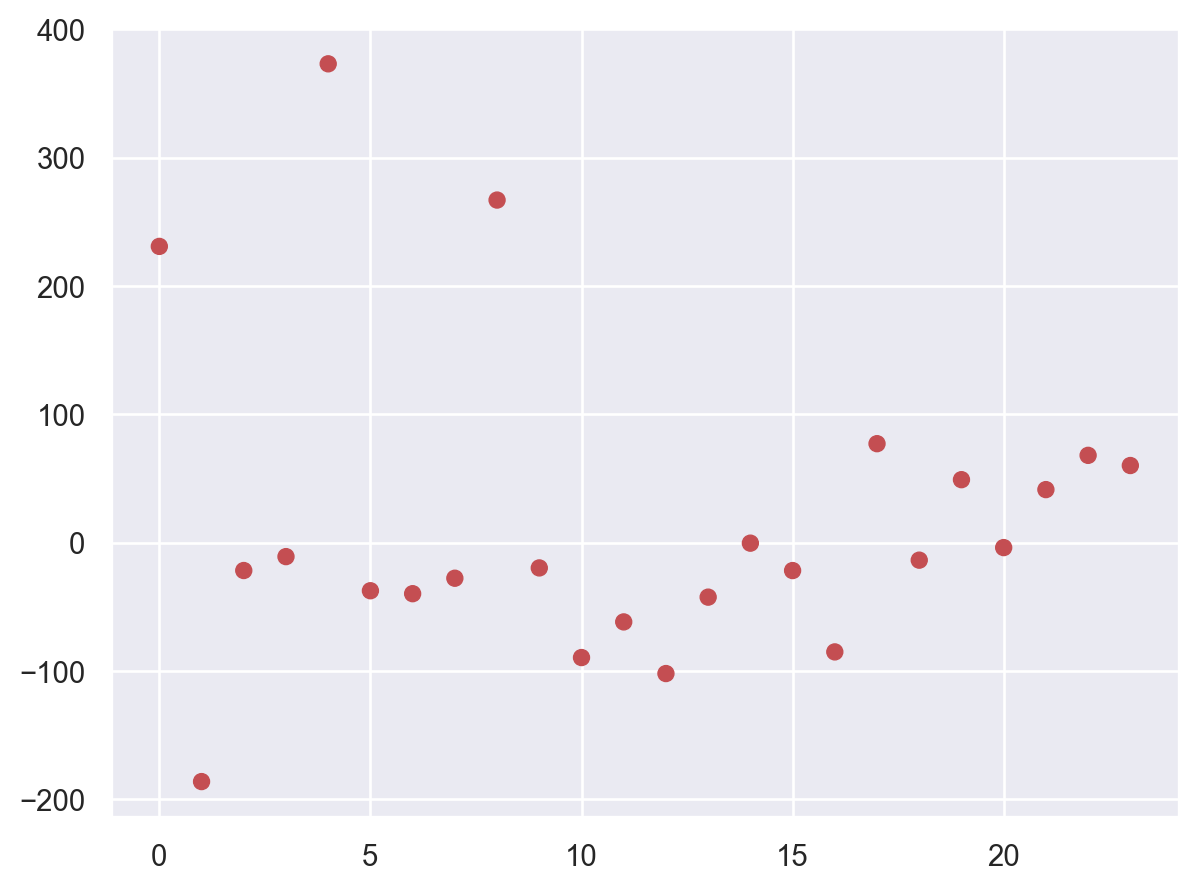

In [66]:
(
    so.Plot(x = np.arange(len(modelo.coef_)))
    .add(so.Dot(color = "r"), y = modelo.coef_)
)

In [50]:
# Miramos los coeficientes en forma prolija
beta1 = pd.Series(modelo.coef_, index=X_train4.columns)
beta1["intercept"] = modelo.intercept_
beta1

poly(a, 4)[1]                  251.653574
poly(a, 4)[2]                 -180.337270
poly(a, 4)[3]                   -6.361335
poly(a, 4)[4]                    1.146740
poly(b, 4)[1]                  353.628321
poly(b, 4)[2]                   38.920650
poly(b, 4)[3]                   -9.438755
poly(b, 4)[4]                   20.895507
poly(a, 4)[1]:poly(b, 4)[1]    495.033985
poly(a, 4)[2]:poly(b, 4)[1]     39.424643
poly(a, 4)[3]:poly(b, 4)[1]    -58.963670
poly(a, 4)[4]:poly(b, 4)[1]     -9.850133
poly(a, 4)[1]:poly(b, 4)[2]     54.242796
poly(a, 4)[2]:poly(b, 4)[2]     95.268164
poly(a, 4)[3]:poly(b, 4)[2]    -12.541478
poly(a, 4)[4]:poly(b, 4)[2]    123.535640
poly(a, 4)[1]:poly(b, 4)[3]    -29.106466
poly(a, 4)[2]:poly(b, 4)[3]     87.252156
poly(a, 4)[3]:poly(b, 4)[3]      2.782401
poly(a, 4)[4]:poly(b, 4)[3]     60.724368
poly(a, 4)[1]:poly(b, 4)[4]     80.488881
poly(a, 4)[2]:poly(b, 4)[4]     30.033537
poly(a, 4)[3]:poly(b, 4)[4]    -31.727286
poly(a, 4)[4]:poly(b, 4)[4]    -25

In [67]:
# O podemos usar Leave-One-Out
# En este esquema, la cantidad de pliegos es igual a la cantidad de observaciones!
modelo = linear_model.RidgeCV(alphas = alfas)
modelo.fit(X_train4, y_train)
modelo.alpha_

0.00021544346900318845

In [55]:
# ECM train
y_pred = modelo.predict(X_train4)
ecm = mean_squared_error(y_train, y_pred)
print('Raiz cuadarada del ECM en entrenamiento: ', np.sqrt(ecm))

# ECM test
y_pred = modelo.predict(X_test4)
ecm = mean_squared_error(y_test, y_pred)
print('Raiz cuadarada del ECM en testeo: ', np.sqrt(ecm))

Raiz cuadarada del ECM en entrenamiento:  3.9111926457526316
Raiz cuadarada del ECM en testeo:  11.822469338062845


In [56]:
modelo.coef_

array([ 254.52099754, -176.89319176,   -4.70681835,    5.58497252,
        358.50965651,   35.35533381,   -0.87047485,   17.45430678,
        698.42435886,  -29.23479441,  -63.78518538,  -11.74766217,
         40.86365844,   53.85889188,   27.11559217,  135.91817425,
          2.81434343,   54.97687432,  -34.85025308,   61.21343836,
         96.23564699,  -29.73780368,   43.57930846,  -47.23997166])

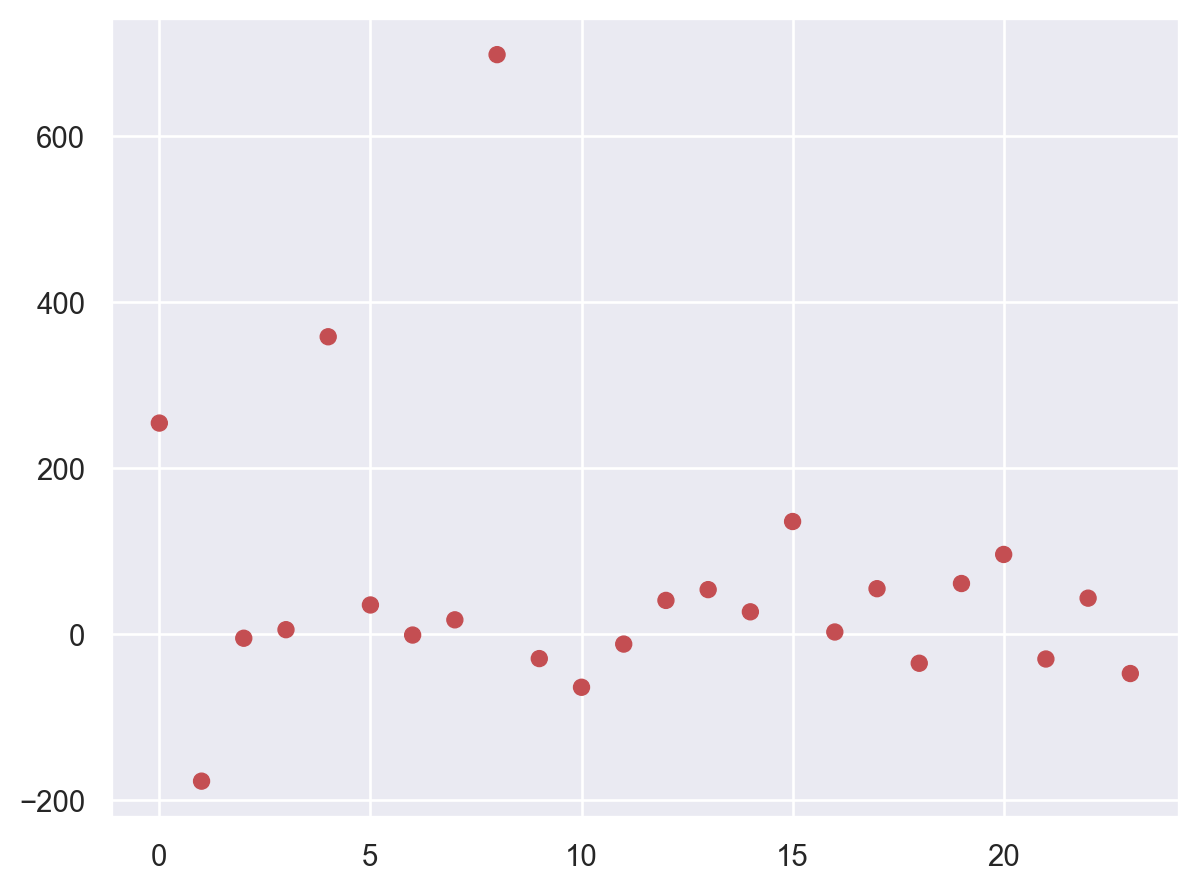

In [57]:
(
    so.Plot(x = np.arange(len(modelo.coef_)))
    .add(so.Dot(color = "r"), y = modelo.coef_)
)

In [59]:
# Miramos los coeficientes en forma prolija
beta1 = pd.Series(modelo.coef_, index=X_train4.columns)
beta1["intercept"] = modelo.intercept_
beta1

poly(a, 4)[1]                  254.520998
poly(a, 4)[2]                 -176.893192
poly(a, 4)[3]                   -4.706818
poly(a, 4)[4]                    5.584973
poly(b, 4)[1]                  358.509657
poly(b, 4)[2]                   35.355334
poly(b, 4)[3]                   -0.870475
poly(b, 4)[4]                   17.454307
poly(a, 4)[1]:poly(b, 4)[1]    698.424359
poly(a, 4)[2]:poly(b, 4)[1]    -29.234794
poly(a, 4)[3]:poly(b, 4)[1]    -63.785185
poly(a, 4)[4]:poly(b, 4)[1]    -11.747662
poly(a, 4)[1]:poly(b, 4)[2]     40.863658
poly(a, 4)[2]:poly(b, 4)[2]     53.858892
poly(a, 4)[3]:poly(b, 4)[2]     27.115592
poly(a, 4)[4]:poly(b, 4)[2]    135.918174
poly(a, 4)[1]:poly(b, 4)[3]      2.814343
poly(a, 4)[2]:poly(b, 4)[3]     54.976874
poly(a, 4)[3]:poly(b, 4)[3]    -34.850253
poly(a, 4)[4]:poly(b, 4)[3]     61.213438
poly(a, 4)[1]:poly(b, 4)[4]     96.235647
poly(a, 4)[2]:poly(b, 4)[4]    -29.737804
poly(a, 4)[3]:poly(b, 4)[4]     43.579308
poly(a, 4)[4]:poly(b, 4)[4]    -47